Luke and Ray has shared the CRISPRi screening results which was analyzed with [ScreenProcessing](https://github.com/mhorlbeck/ScreenProcessing) pipeline. 

- $\gamma$ - gamma score
- $\rho$ - rho score

- Pathway enrichment analysis over the gamma and rho scores
- Load screening result tables into python 
- Make sure gene names are correctly assigned 
- Exploring correlations, differences, and intersections among the screens.


In [18]:
import sys
import pandas as pd
import numpy as np 
from itertools import chain, product

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from venn import venn 


sys.path.append("../")
from util import *

In [19]:
data = load_data(screens=True)

In [20]:
data['hl60'].keys()

dict_keys(['exp1_DAC_rho', 'exp1_DAC_gamma', 'exp2_DAC_rho', 'exp2_DAC_gamma', 'exp2_GSK_rho', 'exp2_GSK_gamma'])

In [4]:
def drug_score_df(data, DRUG, SCORE):
    '''
    A function to read screening data for given score and drug
    '''
    all_genes = [set(data[cell][key].index) for cell in data for key in data[cell] if DRUG in key and SCORE in key]
    genes = all_genes[0].intersection(*all_genes[1:])
    
    keys = ['_'.join([cell,key]) for cell in data for key in data[cell] if DRUG in key and SCORE in key]
    cols = [col[0]+col[1] for col in product(keys,[' score',' pvalue'])]
    
    all_df = [data[cell][key].loc[genes] for cell in data for key in data[cell] if DRUG in key and SCORE in key]
    
    df = pd.concat(all_df, axis=1).dropna().astype(float)
    df.columns = cols
    
    return df

## Phenotype-enrichment analysis
I've selected `ave_Rep1_Rep2` column together with gene names for both $\gamma$ (gamma) and $\rho$ (rho) scores as seprate two-column tables to run iPAGE for phenotype encrichment analysis. 

Run `iPAGE`:

In [21]:
# 'exp1_DAC_gamma'
# 'exp2_DAC_rho'
# 'exp2_DAC_gamma'
# 'exp2_GSK_rho'
# 'exp2_GSK_gamma'
pd.concat(find_top(data['hl60']['exp1_DAC_rho'].astype(float),'rho score',0.2,'Mann-Whitney p-value',0.05)).to_csv('hl60_exp1_DAC_rho_delta_phenotype.txt',sep='\t')

up:  132
down: 173


In [22]:
ls 

check-sum.txt                          img/
downstream-analysis.ipynb              ipage.out
hl60_exp1/                             molm13_exp/
hl60_exp1_DAC_rho_delta_phenotype/     preprocessing.ipynb
hl60_exp1_DAC_rho_delta_phenotype.txt  screen-downstream-analysis.md
hl60_exp2/                             univariate_analysis.R


### Pathway enrichment analysis

In [11]:
!nohup ls *delta_phenotype.txt | parallel -j18 -k bash ~/Projects/ipage-down/ipage_independence1.sh  {} &> ipage.out

nohup: ignoring input and redirecting stderr to stdout


In [16]:
cat ipage.out 

/rumi/shams/abe/Projects/Decitabine-treatment/CRISPRi-screen
________________ human_c1_gs ________________
Reading expression data ... 2 by 305... Done.
Creating hash ... Done
Reading GO names table ... entering
Done.
Reading GO index table ... entering
Done.
go_terms_num: 299
Creating hash table for gene names in gene ontology index file ... Done.
gene num = 287 out of 305 
Creating hash table for gene ontology names ... Done.
Populating the GO profile table ... 287	299
Done.
Writing internal quantized groups ...Done
26 hits go_terms_num = 299
cat 242, mi = 0.03784097, chr17q23
cat 172, mi = 0.03723694, chr12q23
cat 290, mi = 0.03299650, chr1p35
cat 9, mi = 0.02783142, chr2p21
cat 189, mi = 0.02783142, chr11p13
cat 219, mi = 0.02783142, chr16q22
cat 200, mi = 0.02703086, chr15q24
cat 41, mi = 0.02450451, chr1q23
cat 52, mi = 0.02450451, chr15q15
cat 152, mi = 0.02450451, chr11q24
cat 260, mi = 0.02450451, chrXq22
cat 294, mi = 0.02450451, chr16p12
cat 13, mi = 0.01986110, chr3q25
cat 

# Pairwise correlations

Using `.iloc` induced the pandas into an object instead of dataframe, so `corr()` didn't work. Here is the solution: https://stackoverflow.com/questions/55251166/pandas-corr-returning

Then, using https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

### DAC $\gamma$-score

In [25]:
df = drug_score_df(data,'DAC','gamma').filter(like='score',axis=1)
plot_corr(df)
df.corr().style.background_gradient(cmap='coolwarm',axis=None,vmin=0.5)

TypeError: plot_corr() missing 1 required positional argument: 'title'

### DAC $\rho$-score

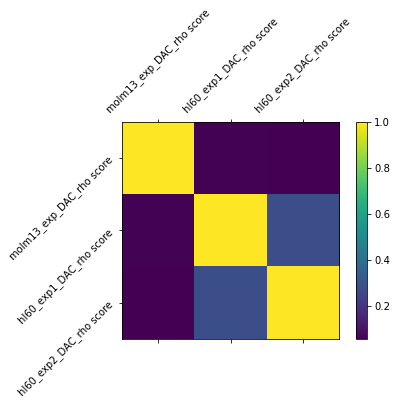

,molm13_exp_DAC_rho score,hl60_exp1_DAC_rho score,hl60_exp2_DAC_rho score
molm13_exp_DAC_rho score,1.000000,0.062309,0.056783
hl60_exp1_DAC_rho score,0.062309,1.000000,0.282337
hl60_exp2_DAC_rho score,0.056783,0.282337,1.000000


In [8]:
df = drug_score_df(data,'DAC','rho').filter(like='score',axis=1)
plot_corr(df)
df.corr().style.background_gradient(cmap='coolwarm',axis=None)

# Intersection

In [9]:
def intersection_analysis(SCORE,score_thr = 0.1,pvalue_thr = 1):

    raw_df = drug_score_df(data,'DAC',SCORE)
    exps = set([col.split(f'_{SCORE}')[0] for col in raw_df.columns.tolist()])

    dfs = [[e,raw_df.filter(like=e,axis=1)] for e in exps]

    results = []
    for exp in dfs:
        print(exp[0])
        results.append([exp[0]] + [find_top(
            exp[1],
            f'{exp[0]}_{SCORE} score', score_thr,
            f'{exp[0]}_{SCORE} pvalue', pvalue_thr
        )])

    studies = dict()
    for res in results:
        up,dn = res[1]
        studies[res[0]] = {}
        studies[res[0]]['up'] = set(up.index)
        studies[res[0]]['dn'] = set(dn.index)

    _, axs = subplots(ncols=2, nrows=1, figsize=(15, 5))

    venn(dict([[std,studies[std]['up']] for std in studies]),fontsize=10,legend_loc="upper left",ax=axs[0])
    axs[0].set_title(f"Up\n{SCORE} score >= {score_thr} &\n P-Value < {pvalue_thr}",fontsize=16)

    venn(dict([[std,studies[std]['dn']] for std in studies]),fontsize=10,legend_loc="upper left",ax=axs[1])
    axs[1].set_title(f"Down\n{SCORE} score <= {-1*score_thr} &\n P-Value < {pvalue_thr}",fontsize=16)

    plt.show()

In [10]:
# def find_hits(df, pvalue_thr = 0.05, score_thr = 0.1):
#     up = df.index[
#         (df.iloc[:,0] >= score_thr) &
#         (df.iloc[:,1] < pvalue_thr)
#     ]
#     dn = df.index[
#         (df.iloc[:,0] <= -1*score_thr) &
#         (df.iloc[:,1] < pvalue_thr)
#     ]
    
#     return up, dn

### DAC $\rho$-score

hl60_exp2_DAC
up:  3170
down: 2819
molm13_exp_DAC
up:  3837
down: 4027
hl60_exp1_DAC
up:  1109
down: 1616


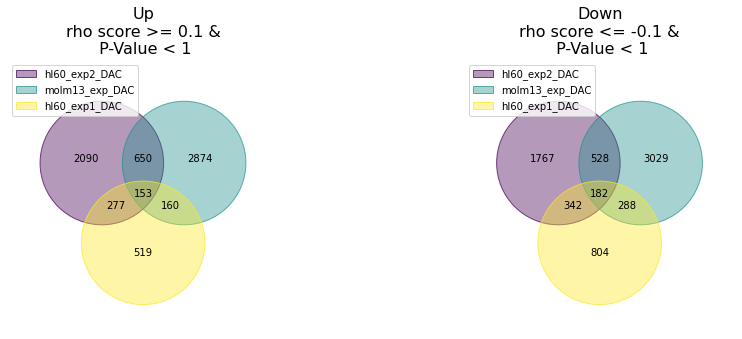

In [11]:
intersection_analysis('rho')

### DAC $\gamma$-score

hl60_exp2_DAC
up:  1215
down: 3044
molm13_exp_DAC
up:  271
down: 3767
hl60_exp1_DAC
up:  39
down: 1447


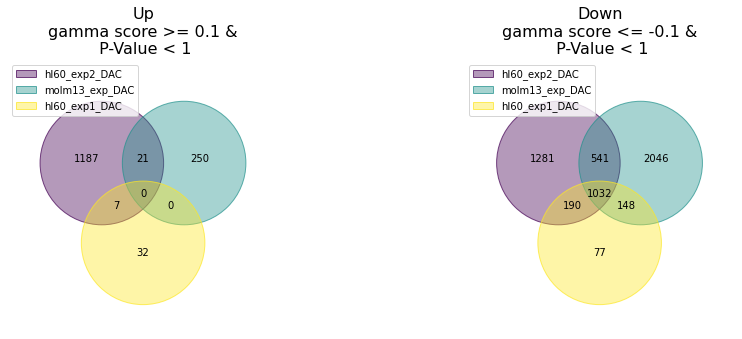

In [12]:
intersection_analysis('gamma')

## m6A reader and writer genes 
[Table 1](https://www.nature.com/articles/s41419-017-0129-x/tables/1) at
> Dai, D., Wang, H., Zhu, L. et al. N6-methyladenosine links RNA metabolism to cancer progression. _Cell Death Dis_ **9**, 124 (2018). https://doi.org/10.1038/s41419-017-0129-x

In [70]:
table = pd.read_csv('../m6A-genes.tsv', sep = '\t')

# Clean and filter above table to take matched gene names for further analysis:
m6A_genes = table.Names.tolist()
RBMs = m6A_genes[4].split(' and its paralogue ')
m6A_genes.remove(m6A_genes[4])
m6A_genes = m6A_genes+RBMs

table 

,Type,Names,Functional classification,Functions in m6A regulation and RNA metabolism,References (Pubmed ID)
0,m6A writer,METTL3,Catalytic m6A methyltransferase,"Create m6A sites (most near 3_ UTRs, catalytic...",24316715
1,m6A writer,METTL14,Subunit of METTL3 m6A methyltransferase complex,Help METTL3 to recognize substrate,27373337
2,m6A writer,WTAP,Subunit of METTL3 m6A methyltransferase complex,Adaptor protein to lead METTL3ÐMETTL14 heterod...,24981863
3,m6A writer,KIAA1429,Subunit of METTL3 m6A methyltransferase complex,Adaptor protein to lead METTL3ÐMETTL14 heterod...,24981863
4,m6A writer,RBM15 and its paralogue RBM15B,Subunit of METTL3 m6A methyltransferase complex,Determine which DRACH sites are methylated,27602518
5,m6A writer,METTL16,Catalytic m6A methyltransferase,"m6A sitesÊcreation (most in introns, catalytic...",28525753
6,m6A eraser,FTO,m6A demethylase (catalytic site is H231 and D233),"RNA demethylation, mRNA splicing",25412662
7,m6A eraser,ALKBH5,m6A demethylase (catalytic site is H204 or H266),"RNA demethylation, mRNA processing, mRNA expor...","23177736, 28344040"
8,m6A reader,YTHDC1,Direct reader,mRNA splicing,26876937
9,m6A reader,YTHDF1,Direct reader,mRNA translation,26046440


Add heatmap!

In [86]:
def plot_score_heatmap(score, drug, genes):
    df = drug_score_df(data,drug,score)
    # keep non-missing gene names 
    genes = [gene for gene in genes if gene in df.index.tolist()]

    # draw heatmap
    sns.set_theme()

    sc_df = df.loc[genes].filter(like='score')
    sc_df.columns = [c.replace(f'_{score} score','') for c in sc_df.columns]
    
    pv_df= df.loc[genes].filter(like='pvalue')
    pv_df.columns = [c.replace(f'_{score} pvalue','') for c in pv_df.columns]

    _, (ax1,ax2) = subplots(ncols=2, nrows=1, figsize=(15, 5))

    pv = sns.heatmap(pv_df, vmin=0, vmax=0.05, annot=True, linewidth=0.1,ax=ax1, cbar=False,cmap="YlGnBu")
    pv.set_ylabel('')
    pv.set_xlabel('')
    ax1.set_title('P-Values', fontsize=15)

    sc = sns.heatmap(sc_df, vmin=-0.2, vmax=0.2, annot=True, linewidth=0.1,ax=ax2,yticklabels=False)
    sc.set_ylabel('')
    sc.set_xlabel('')
    ax2.set_title(f'{score} scores', fontsize=15)

    # rotate the ticklabels correctly:
    for ax in [sc,pv]:
        tl = ax.get_xticklabels()
        ax.set_xticklabels(tl, rotation=45)
    plt.show()

### Rho score of DAC m6A genes 

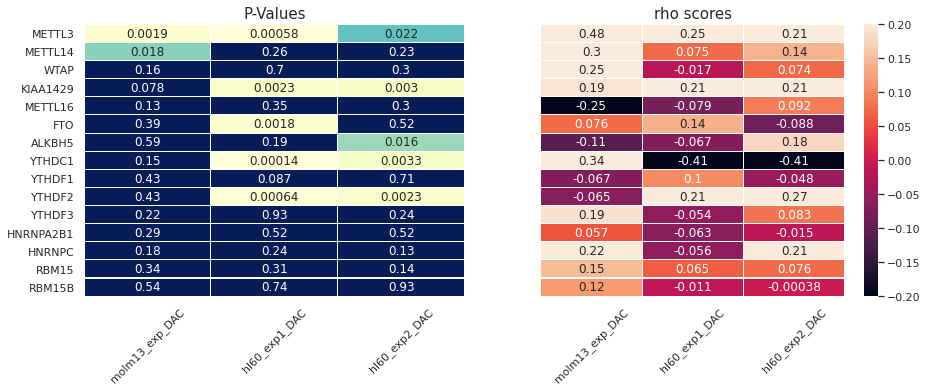

In [96]:
plot_score_heatmap('rho', 'DAC', m6A_genes)

### Rho score of GSK m6A genes 

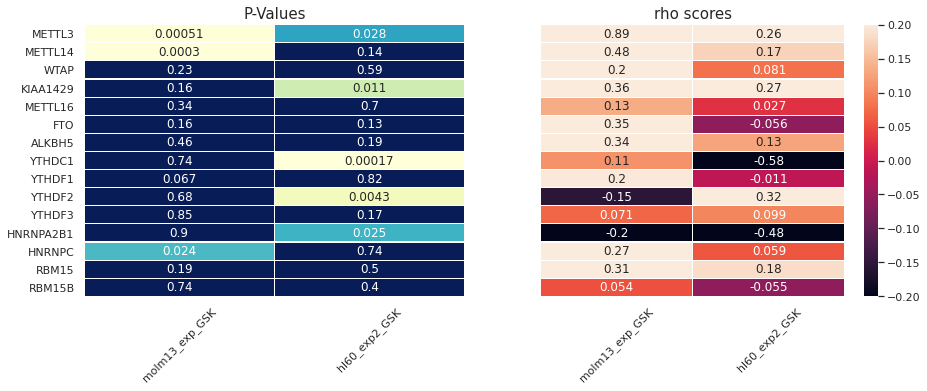

In [97]:
plot_score_heatmap('rho', 'GSK', m6A_genes)

In [ ]:
# %reload_ext rpy2.ipython

In [ ]:
# %%R 
# library (ggplot2)

# plot_Save <- function (p, name_it){
#     ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
#     ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)
# }


# plot_Hist = function(res, title, x_min=-0.5,x_max=0.5){
# #     w <- wilcox.test(res$logFC, mu=0, alternative = "greater")
# #     t <- t.test(res$logFC, mu=0, alternative = "greater")
#     h = ggplot(res, aes(x=logFC)) + 
#         ggtitle(title) +#,sprintf(
# #             "wilcox.test (-log10 p.value): %.5f \nt.test (-log10 p.value):%.5f \n[mu=0,alter=greater]", 
# #             -log10(w$p.value), -log10(t$p.value))) +
#         xlim(c(x_min,x_max)) +
#         geom_histogram(binwidth=0.001)

#     return (h)
# } 


In [ ]:
# %%R -i res
# plot_Hist(res, 'Rho score')